<a href="https://colab.research.google.com/github/yazdipour/image-processing-tasks/blob/main/CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# NumPy
import numpy as np

# PyTorch
import torch
import torch.nn.functional as F
import torch.nn as nn
# Torchvision
import torchvision

# PyTorch Lightning
import pytorch_lightning as pl

# Accuracy Metrik
from torchmetrics.classification import Accuracy

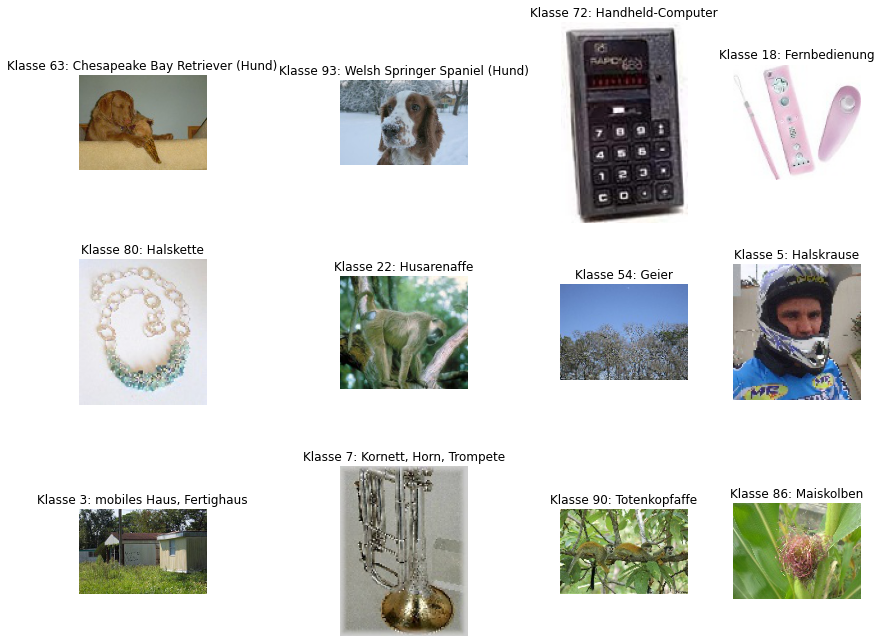

In [ ]:
# Datensatzobjekt erstellen
train_dataset = DL4CVDataset(root='./', split='train')
plot_samples([train_dataset[i]
              for i in np.random.permutation(len(train_dataset))[:12]],
             class_names=train_dataset.classes)

In [ ]:
class LeNet(torch.nn.Module):
    def __init__(self, n_classes=100):
        super(LeNet, self).__init__()

        # Schichten anlegen
        self.conv1 = torch.nn.Conv2d(3, 96, kernel_size=7, stride=2)
        self.pool = torch.nn.MaxPool2d(2, 2)

        self.conv2 = torch.nn.Conv2d(96, 16, kernel_size=5, padding=0)

        self.fc1_dropout = torch.nn.Dropout(p=0.5)
        self.fc1 = torch.nn.Linear(400, 120)    # 400 = 16*5*5

        self.fc2_dropout = torch.nn.Dropout(p=0.5)
        self.fc2 = torch.nn.Linear(120, 100)

        self.fc3 = torch.nn.Linear(100, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 400)

        x = self.fc1_dropout(x)
        x = F.relu(self.fc1(x))

        x = self.fc2_dropout(x)
        x = F.relu(self.fc2(x))

        return self.fc3(x)

In [ ]:
class AlexNet(torch.nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = torch.nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = torch.nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = torch.nn.Linear(in_features=4096 , out_features=100)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class ZFNet(torch.nn.Module):
    def __init__(self):
        super(ZFNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 7, stride=2, padding=2 )
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 2, padding= 2)
        self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.conv5 = torch.nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.fc1  = torch.nn.Linear(in_features= 18432, out_features= 4096)
        self.fc2  = torch.nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = torch.nn.Linear(in_features=4096 , out_features=100)
        self.drop1 = torch.nn.Dropout(0.5, inplace=False)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.drop1(x)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(torch.nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()        
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, 100))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
class MyNetworkLightningModule(pl.LightningModule):
    def __init__(self):
        super(MyNetworkLightningModule, self).__init__()
        self.network = PropablyNotTheBestNetworkArchitecture()
        self.accuracy_top1 = Accuracy(top_k=1)
        self.accuracy_top5 = Accuracy(top_k=5)

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self.network(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self.network(x)
        self.log('val_loss', F.cross_entropy(y, t),
                 on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc_top1', self.accuracy_top1(y, t),
                 on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc_top5', self.accuracy_top5(y, t),
                 on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        # return torch.optim.SGD(self.parameters(),
        #                        lr=0.01,
        #                        momentum=0.9)
        max_lr = 0.001
        optimizer = torch.optim.AdamW(self.parameters(), 
                                lr= max_lr, 
                                weight_decay=1e-1) #Adam seems to be the most popular for deep learning
        # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,total_steps=30)
        # return [optimizer], [sched]
        return optimizer
  
    def train_dataloader(self):
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomCrop(96, padding=4, padding_mode='reflect'),     
            torchvision.transforms.Resize(32),
            torchvision.transforms.RandomHorizontalFlip(),
            # torchvision.transforms.ColorJitter(hue=0.08, brightness=0.3, saturation= 0.4, contrast= 0.3),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        dataset = DL4CVDataset(root='./', split='train', transform=transforms)
        return torch.utils.data.DataLoader(dataset,
                                           batch_size=100,
                                           shuffle=True,
                                           num_workers=8)

    def val_dataloader(self):
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop(100),
            torchvision.transforms.Resize(32),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        dataset = DL4CVDataset(root='./', split='val', transform=transforms)
        return torch.utils.data.DataLoader(dataset,
                                           batch_size=100,
                                           shuffle=False,
                                           num_workers=8)

    def test_dataloader(self):
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop(100),
            torchvision.transforms.Resize(32),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        dataset = DL4CVDataset(root='./', split='test', transform=transforms)
        return torch.utils.data.DataLoader(dataset,
                                           batch_size=100,
                                           shuffle=False,
                                           num_workers=8)

In [ ]:
network = MyNetworkLightningModule()
checkpoint_cb = pl.callbacks.ModelCheckpoint(
    save_top_k=1,
    verbose=False,
    monitor='val_acc_top1',
    mode='max',
)
trainer = pl.Trainer(default_root_dir='./results',
                     gpus=1,   
                     max_epochs=50,
                     callbacks=checkpoint_cb)

trainer.fit(network)

In [ ]:
# fuer eigenes Jupyter Notebook und Colab
%load_ext tensorboard
%tensorboard --logdir ./results/lightning_logs/

Lade Checkpoint: results/lightning_logs/version_1/checkpoints/epoch=9-step=4999.ckpt


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

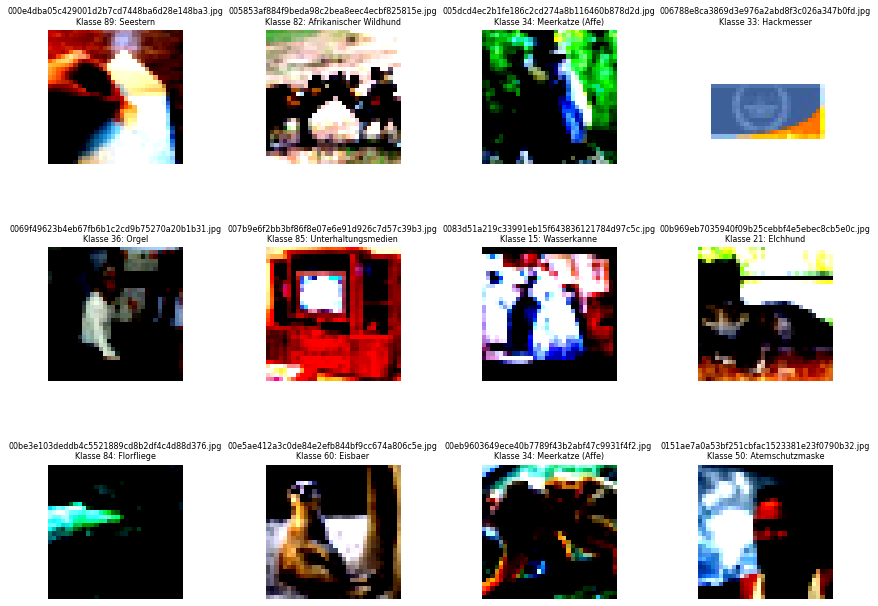

In [ ]:
print(f"Lade Checkpoint: {checkpoint_cb.best_model_path}")
best_network = MyNetworkLightningModule.load_from_checkpoint(checkpoint_cb.best_model_path)
best_network.eval()
for filenames, (x, _) in network.test_dataloader():
    logits = best_network(x.to(best_network.device))
    y = logits.argmax(dim=1).cpu().numpy()
    imgs = x.permute(0, 2, 3, 1).cpu().numpy()
    plot_samples([(filenames[i], (imgs[i], y[i])) for i in range(12)],
                 class_names=network.test_dataloader().dataset.classes)
    break